In [13]:
!ls /projectnb/textconv/dgwave/AudioSCC/data/digits_two

0.wav	1.wav	19.wav	3.wav	47.wav	55.wav	62.wav	7.wav	79.wav	92.wav
00.wav	11.wav	2.wav	30.wav	49.wav	56.wav	63.wav	72.wav	8.wav	94.wav
02.wav	13.wav	23.wav	4.wav	5.wav	59.wav	64.wav	75.wav	86.wav	96.wav
05.wav	14.wav	26.wav	41.wav	51.wav	6.wav	66.wav	76.wav	89.wav	97.wav
09.wav	15.wav	28.wav	45.wav	53.wav	60.wav	67.wav	78.wav	9.wav	98.wav


In [14]:
from IPython.display import Audio
import torch
import os
from scipy.io import wavfile
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# Play the .wav file
Audio("/projectnb/textconv/dgwave/AudioSCC/data/digits_two/0.wav")

In [15]:
sample_rate, data = wavfile.read("/projectnb/textconv/dgwave/AudioSCC/data/digits_two/1.wav")

In [16]:
sample_rate

24000

In [17]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU.")

Using GPU: Tesla V100-SXM2-16GB


In [18]:
class WaveformDatasetPreload(Dataset):
    def __init__(self, directory, t_input, max_len, terminal_pad, seq_vocab_len, seq_max_len, seq_t):
        """
        directory: Directory containing the .wav files.
        t_input: Time input array for all files.
        max_len: Maximum length of time steps needed for all files.
        terminal_pad: Number of zeros to pad at the end of each audio file.
        seq_max_len: maximum len of input sequence in tokens.
        """
        self.directory = directory
        self.files = sorted([f for f in os.listdir(directory) if f.endswith('.wav')][:100], key=lambda x: int(x.split('.')[0]))
        self.t_input = t_input # max is taken care of outside.

        self.terminal_pad = terminal_pad  # Fixed number of zeros to pad
        self.seq_max_len = seq_max_len  # Maximum number of integers in the filename sequence
        self.seq_t = seq_t[:seq_max_len]
        self.seq_vocab_len = seq_vocab_len
        # Preload and pad filenames
        self.padded_file_name_integers = self._prepare_padded_filenames()

        # **Change here**: Preload and pad audio files during initialization
        self.wav_data_list = [self._load_and_pad(os.path.join(directory, f)) for f in self.files]
        self.file_indices = []
        self.total_length = 0

        # Calculate lengths of all files and their indices
        for i, wav_data in enumerate(self.wav_data_list):
            length = wav_data.size(1)  # Assuming data is [channels, time], we take the time dimension
            self.file_indices.extend([(i, j) for j in range(length)])
            self.total_length += length

    def _prepare_padded_filenames(self):
        """
        Converts filenames into sequences of integers, right-padded with 0s up to seq_max_len length.
        """
        padded_filenames = []
        for file_name in self.files:
            # Extract the number from the file name (without the '.wav' extension)
            file_name_base = file_name.split('.')[0]
            # Convert the number into a list of integers
            file_name_integers = [int(char) for char in file_name_base]
            # Pad the list with zeros until it matches the required length
            padded_file_name = file_name_integers + [self.seq_vocab_len] * (self.seq_max_len - len(file_name_integers))
             #### embedding_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=10) required!
            # Convert to PyTorch tensor
            padded_filenames.append(torch.tensor(padded_file_name, dtype=torch.long))
        return padded_filenames

    def _load_and_pad(self, file_path):
        """
        **Change here**: Load and pad audio file only once during initialization.
        """
        sample_rate, data = wavfile.read(file_path)
        data = torch.tensor(data).unsqueeze(0)  # Convert to tensor and add channel dimension

        # Normalize the data to the range [-1, 1] based on int16
        if data.dtype == torch.int16:
            data = data / 32768.0  # Normalize int16 data
        elif data.dtype == torch.int32:
            data = data / 2147483648.0  # Normalize int32 data
        elif data.dtype == torch.float32:
            pass  # If it's already float, assume it's in [-1, 1]

        # Pad the data with zeros at the end
        pad_length = self.terminal_pad
        data_padded = torch.nn.functional.pad(data, (0, pad_length), mode='constant', value=0)
        return data_padded

    def _generate_target(self, wav_data):
        """
        Helper function to generate the target tensor.
        The target will have 1 in all positions except for the final terminal_pad zeros.
        """
        target = torch.ones_like(wav_data)  # Create a target tensor with all ones
        # Set the last terminal_pad positions to zero
        target[:, -self.terminal_pad:] = 0
        return target

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        # **No file loading happens here**; just retrieving preloaded data
        file_idx, local_idx = self.file_indices[idx]
        wav_data = self.wav_data_list[file_idx][:, local_idx]  # Slice based on channel and index
        t_step = self.t_input[local_idx]  # Time input for the specific index
        target = self._generate_target(self.wav_data_list[file_idx])[:, local_idx]  # Generate the target tensor

        # Return the preprocessed padded file name integers for the given file_idx
        padded_file_name_integers = self.padded_file_name_integers[file_idx]

        num_padding = (padded_file_name_integers == self.seq_max_len).sum().item()

        # Retain only non-padded values in seq_t and zero out the rest
        retained_len = len(self.seq_t) - num_padding
        seq_t_adjusted = self.seq_t.clone()  # Clone to avoid modifying the original tensor
        if retained_len > 0:
            seq_t_adjusted[retained_len:] = 0  # Zero out the right-padded elements

        return wav_data, t_step, target, padded_file_name_integers, seq_t_adjusted

In [19]:


class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        """
        data_source: Dataset that returns (wav_data, time_step, file_idx)
        batch_size: Number of consecutive segments in each batch
        consecutive_size: How many consecutive steps to take for each sampled segment
        """
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size

class ConsecutiveDifferenceHigherOrderLossBatch(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLossBatch, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor(0.0, device=prediction.device)
        
        pred_a = pred_reshape[ 1:, :]
        pred_b = pred_reshape[:-1,:]
        target_a = target_reshape[ 1:, :]
        target_b = target_reshape[:-1,:]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[ 1:, :]
            pred_b = pred_dif[:-1,:]
            target_a = target_dif[ 1:, :]
            target_b = target_dif[:-1,:]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result
    
class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor(0.0, device = prediction.device)
        
        pred_a = pred_reshape[:, 1:]
        pred_b = pred_reshape[:, :-1]
        target_a = target_reshape[:, 1:]
        target_b = target_reshape[:, :-1]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[:, 1:]
            pred_b = pred_dif[:, :-1]
            target_a = target_dif[:, 1:]
            target_b = target_dif[:, :-1]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result


def get_max_required_length(dir):
    max_length = 0
    
    # Iterate over all files in the directory
    for filename in os.listdir(dir):
        if filename.endswith('.wav'):  # Only process .wav files
            file_path = os.path.join(dir, filename)
            
            # Read the .wav file
            sample_rate, data = wavfile.read(file_path)
            
            # Get the length of the audio file (number of samples)
            file_length = data.shape[0]  # shape[0] gives the number of samples (time dimension)
            
            # Update the max length if this file is longer
            if file_length > max_length:
                max_length = file_length

    return max_length

#import torch
#import torch.nn as nn
#import torch.optim as optim



def binary_sequence_tensor(num_bits, length):
    # Create a tensor of shape (length,) with values from 0 to length - 1
    t_values = torch.arange(1,length+1) #start with 1

    # Create a tensor to store the binary representations
    binary_tensor = ((t_values.unsqueeze(1) >> torch.arange(num_bits)) & 1).float()
    #binary_tensor[binary_tensor == 0] = -1
    return binary_tensor
    

In [20]:
directory = "/projectnb/textconv/dgwave/AudioSCC/data/digits_two/"
max_len = get_max_required_length(directory) 
max_len

27413

In [21]:
target_pad = 5
bits = 20 #for the other models b
seq_bits = 1
seq_max_len = 2
seq_vocab_len = 10

In [ ]:
num_bits = bits
length = 100000

t_res = binary_sequence_tensor(num_bits, length)

def find_max_changes_indices(binary_tensor, index):
    # Check the shape of the tensor
    if binary_tensor.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional (length x bits).")

    if index < 0 or index >= binary_tensor.size(0):
        raise ValueError("Index must be within the range of the first dimension of the tensor.")

    # Calculate changes with respect to the specified index
    target_row = binary_tensor[index]
    changes = torch.sum(binary_tensor != target_row, dim=1)  # Count changes for each row compared to the target row

    # Find the indices with the maximum number of changes
    max_changes = changes.max().item()
    max_change_indices = torch.nonzero(changes == max_changes).squeeze().tolist()

    return max_change_indices
print(find_max_changes_indices(t_res, 0))


def shuffle_tensor(tensor):
    # Check if the input tensor is 2-dimensional
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional (length x bits).")

    length = tensor.size(0)
    shuffled_tensor = torch.zeros_like(tensor)

    # Rearranging indices: first last, second second to last, etc.
    for i in range(length):
        if i % 2 == 0:  # Even indices: take from the front
            shuffled_tensor[i] = tensor[i // 2]
        else:  # Odd indices: take from the back
            shuffled_tensor[i] = tensor[length - (i // 2) - 1]

    return shuffled_tensor

t_shuffled = shuffle_tensor(t_res[:65533])
print(t_shuffled.shape)

def calculate_changes_distribution(tensor):
    # Check the shape of the tensor
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional (length x bits).")

    # Calculate the number of changes between consecutive rows
    changes = torch.sum(tensor[1:] != tensor[:-1], dim=1)  # Compare consecutive rows

    # Create a histogram of the changes
    change_distribution = torch.bincount(changes)

    return change_distribution

def plot_changes_distribution(distribution):
    # Plot the distribution of changes
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(distribution)), distribution.numpy())
    plt.xlabel('Number of Changes')
    plt.ylabel('Frequency')
    plt.title('Distribution of Changes Between Consecutive Rows')
    plt.xticks(range(len(distribution)))
    plt.grid(axis='y')
    plt.show()

    
changes_distribution = calculate_changes_distribution(t_shuffled[:max_len])
plot_changes_distribution(changes_distribution)

In [ ]:
from scipy.special import legendre 
def generate_legendre_tensor(length, hidden_dim):
    # Generate a tensor to hold the Legendre polynomial values
    tensor = torch.zeros((length, hidden_dim))

    # Generate Legendre polynomials and populate the tensor
    for n in range(hidden_dim):
        # Create an array of x values between -1 and 1
        x_values = np.linspace(-1, 1, length)
        # Calculate the Legendre polynomial for degree n
        P_n = legendre(n)(x_values)

        # Normalize to [0, 1]
        P_n_min = P_n.min()
        P_n_max = P_n.max()
        if P_n_max > P_n_min:  # Avoid division by zero
            normalized_P_n = (P_n - P_n_min) / (P_n_max - P_n_min)
        else:
            normalized_P_n = np.zeros_like(P_n)  # All values are the same

        # Convert to PyTorch tensor and assign
        tensor[:, n] = torch.tensor(normalized_P_n, dtype=torch.float32)

    # Set one entry to 1 (intercept) and adjust others to be close to 0.5
    intercept_index = np.random.randint(hidden_dim)
    tensor[:, intercept_index] = 1.0  # Set intercept to 1

    # Normalize again to ensure all values stay between 0 and 1
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)  # Adding a small value to avoid division by zero

    return tensor
t_leg = generate_legendre_tensor(max_len + 100, hidden_dim = bits)
changes_distribution = calculate_changes_distribution(t_leg)
plot_changes_distribution(changes_distribution)

In [23]:
t_input = binary_sequence_tensor(bits, max_len+ target_pad + 1 )  # Example, adjust this to match your real t_input
#t_input = t_shuffled[:max_len+ target_pad + 1]
#t_input = t_leg[:max_len+ target_pad + 1]
t_seq = binary_sequence_tensor(seq_bits, seq_max_len )

seq_t_input = binary_sequence_tensor(seq_bits, seq_max_len + 1) 


#this is for validating
#t_input = np.linspace(1,max_len + target_pad,max_len + target_pad)

# Instantiate the dataset directory, t_input, max_len, terminal_pad, seq_vocab_len, seq_max_len, seq_t
dataset = WaveformDatasetPreload(directory, t_input, max_len, target_pad ,seq_vocab_len, seq_max_len,t_seq )

# Sampler setup as before
batch_size = 200
consecutive_size = 20
sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)

# DataLoader
dataloader = DataLoader(dataset, batch_sampler=sampler, num_workers=4)

In [24]:
for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs = batch #right now this wraps arround, just fyi.  not sure its a bad thing.


    print("Waveform data:", wav_data.shape)
    print("Time step:", t_step.shape)
    print("Target tensor:", target.shape)
    print("File index:", file_idx.shape)
    print("File index:", seq_inputs.shape)
    break

Waveform data: torch.Size([4000, 1])
Time step: torch.Size([4000, 20])
Target tensor: torch.Size([4000, 1])
File index: torch.Size([4000, 2])
File index: torch.Size([4000, 2, 1])


In [25]:
import sys
models_path = '/projectnb/textconv/dgwave/AudioSCC/models'
sys.path.append(models_path)

In [26]:
from SwissArmyModel import SeqModel
config = {
    't_seq_bits': seq_bits,  # Example value for the input bit size
    't_seq_len': seq_max_len,    # Example value for the sequence length
    't_bits': bits,      # Example value for the bits used in the decoder

    'encoder': {
        't_layer_dim': 50,               # Example hidden layer dimension for encoder
        't_num_layers': 1,                # Example number of layers in the encoder's initial layer
        'fc_layers': 5,                   # Example number of fully connected layers in the encoder
        'encoder_layers': 2,              # Example number of encoder layers
        'one_hot_vocab_len': 10,          # Vocabulary size for one-hot encoding
        'one_hot_embedding_dim': 60       # Embedding dimension for one-hot encoding
    },

    'decoder': {
        't_layer_dim': 50,                # Example hidden layer dimension for decoder
        't_num_layers': 1,                # Example number of layers in the decoder's initial layer
        'fc_layers': 5,                   # Example number of fully connected layers in the decoder
        'decoder_layers': 5                # Example number of decoder layers
    },

    'output': {
        'mse_output_layers': 3,           # Number of layers in the MSE output head
        'mse_dim': 128,                     # Hidden dimension for the MSE output head
        'bce_output_layers': 3,            # Number of layers in the BCE output head
        'bce_dim': 64                      # Hidden dimension for the BCE output head
    }
}


In [27]:
model = SeqModel(config)

In [28]:
model.to(device)

SeqModel(
  (encoder): SeqEncoder(
    (initial_layer): SwissArmyLayer(
      (t_layers): ModuleList(
        (0): Linear(in_features=1, out_features=50, bias=True)
      )
      (embedding): Embedding(11, 60, padding_idx=10)
      (layers): ModuleList(
        (0): Linear(in_features=110, out_features=110, bias=True)
        (1): Linear(in_features=110, out_features=110, bias=True)
        (2): Linear(in_features=110, out_features=110, bias=True)
        (3): Linear(in_features=110, out_features=110, bias=True)
        (4): Linear(in_features=110, out_features=110, bias=True)
      )
    )
    (encoder_layers): ModuleList(
      (0): SwissArmyLayer(
        (t_layers): ModuleList(
          (0): Linear(in_features=1, out_features=50, bias=True)
        )
        (embedding): Embedding(11, 60, padding_idx=10)
        (layers): ModuleList(
          (0): Linear(in_features=220, out_features=220, bias=True)
          (1): Linear(in_features=220, out_features=220, bias=True)
          (2)

In [ ]:
#model = torch.load("digitssamodel_more.pth")

In [ ]:
model.encoder.initial_layer.embedding.weight

In [ ]:
for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs = batch #right now this wraps arround, just fyi.  not sure its a bad thing.
    print(file_idx)

    f = model(seq_inputs,file_idx,t_step)
    print(f)
    break

In [ ]:
layer1_output = []
def get_layer_output(module, input, output):
    layer1_output.append(output)

layer1_gradients = []  # List to store the gradients

def get_layer_gradients(module, grad_input, grad_output):
    layer1_gradients.append(grad_output[0])

terminal_gradients = []
def get_layer_gradients_t(module, grad_input, grad_output):
    terminal_gradients.append(grad_output[0])

In [ ]:
model.decoder.decoder_layers[0].layers[0]

In [ ]:
layer1_output[-1][0:5]

In [ ]:
model.encoder.initial_layer.embedding.register_forward_hook(get_layer_output)
model.encoder.initial_layer.embedding.register_backward_hook(get_layer_gradients)
model.decoder.decoder_layers[0].layers[0].register_backward_hook(get_layer_gradients_t)

In [ ]:
# for tomorrow, tidy up the hyperparam.  no duplicates, and now multiple inputs for things that must be equal.  
#train!!
#also, add some distance from their common embedding from the binary thing to the wav output thing.  

In [32]:
from tqdm import tqdm 

In [59]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:

# Assuming `model` is your SeqModel instance
encoder_params = list(model.encoder.parameters())
decoder_params = list(model.decoder.parameters())
output_params = list(model.mse_head.parameters()) + list(model.bce_head.parameters())

# Set learning rates
encoder_lr = 0.1  # Lower learning rate for the encoder
other_lr = 0.001   # Normal learning rate for other layers

# Create parameter groups
optimizer = optim.Adam([
    {'params': encoder_params, 'lr': encoder_lr},
    {'params': decoder_params + output_params, 'lr': other_lr},
    {'params': bce_params, 'lr': bce_lr}
])

# Now you can use this optimizer in your training loop


In [ ]:
#### i want to have bce only train the bce head.  i am not sure i am even going to use mse.  
##that is param groups

In [62]:
mse_loss_fn = nn.MSELoss().to(device)
bce_loss_fn = nn.BCELoss()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)

num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #for batch in dataloader:
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        wav_data, t_step, target, file_idx, seq_inputs  = batch
        wav_data = wav_data.to(device)
        t_step = t_step.to(device)
        target = target.to(device)
        file_idx = file_idx.to(device)
        seq_inputs = seq_inputs.to(device)
        
        optimizer.zero_grad()
        bce_output, mse_output = model(seq_inputs,file_idx,t_step)
        # Compute losses
        
        #print(target.device, mse_output.device)
        mse_loss = mse_loss_fn(mse_output*target, wav_data)  # Assuming the target is for MSE
        bce_loss = bce_loss_fn(bce_output, target)  # Assuming the target is for BCE
        cdif = cdif_loss(mse_output*target, wav_data)
        #bc = bc_loss(outputs, targets)
        cdif_b = cdifb_loss(mse_output*target, wav_data)
        
        
        # Combine losses (you can weight them if needed)
        total_loss = 0.0*mse_loss + 0.0*bce_loss + 0.5*cdif  + 0.5*cdif_b
        
        # Backpropagation and optimization
        
        total_loss.backward()
        optimizer.step()
        
    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} MSE: {mse_loss.item():.6f} BCE: {bce_loss.item():.6f} CDIF: {cdif.item():.6f}  Total Loss: {total_loss.item():.8f}")
    torch.save(model, "digitssamodel_more.pth")
print("all done sweetheart <3")

Epoch 1/1:   0%|          | 6/5620 [00:00<09:51,  9.48it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14cd551dee60>
Traceback (most recent call last):
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/share/pkg.8/python3/3.10.12/install/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14cd551dee60><function _MultiProcessingDataLoaderIter.__del__ at 0x14cd551dee60>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at

Epoch 1/1 MSE: 0.010999 BCE: 0.740287 CDIF: 0.001363  Total Loss: 0.04619880
all done sweetheart <3


bce seperate

In [53]:
# Assuming `model` is your SeqModel instance
encoder_params = list(model.encoder.parameters())
decoder_params = list(model.decoder.parameters())
output_params = list(model.mse_head.parameters())
bce_params = list(model.bce_head.parameters())

# Set learning rates
model_lr = 0.0001  # Lower learning rate for the encoder
bce_lr = 0.001   # Normal learning rate for other layers

# Create optimizer with all parameters
optimizer_model = optim.Adam([
    {'params': encoder_params + decoder_params + output_params, 'lr': model_lr}
     # You can use the same lr for BCE head
])

optimizer_bce = optim.Adam([
    {'params': bce_params, 'lr': bce_lr} 
])

In [58]:

bce_loss_fn = nn.BCELoss()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)

num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #for batch in dataloader:
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        wav_data, t_step, target, file_idx, seq_inputs  = batch
        wav_data = wav_data.to(device)
        t_step = t_step.to(device)
        target = target.to(device)
        file_idx = file_idx.to(device)
        seq_inputs = seq_inputs.to(device)
        
        
        optimizer_model.zero_grad()
        optimizer_bce.zero_grad()
        
        bce_output, mse_output = model(seq_inputs,file_idx,t_step)
        # Compute losses
        

        bce_loss = bce_loss_fn(bce_output, target)  # Assuming the target is for BCE
        cdif = cdif_loss(mse_output*target, wav_data)

        cdif_b = cdifb_loss(mse_output*target, wav_data)
        
        
        # Combine losses (you can weight them if needed)
        total_loss =  0.6*cdif  + 0.5*cdif_b
        
        # Backpropagation and optimization
        
        total_loss.backward(retain_graph=True)

        
        optimizer_model.step()
        
        
        #bce_loss.backward()
        #optimizer_bce.step()
        
    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} BCE: {bce_loss.item():.6f} CDIF: {cdif.item():.6f}  Total Loss: {total_loss.item():.8f}")
    #torch.save(model, "digitssamodel_more.pth")
print("all done sweetheart <3")




Epoch 1/1:   0%|          | 6/5620 [00:00<09:22,  9.98it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14cd551dee60>
Traceback (most recent call last):
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/share/pkg.8/python3/3.10.12/install/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14cd551dee60><function _MultiProcessingDataLoaderIter.__del__ at 0x14cd551dee60>

Traceback (most recent call last):
Traceback (most recent call last):
  F

KeyboardInterrupt: 

In [ ]:
###torch.save(model, "good_big_new_t.pth") #this is the one that i got excited about.  

In [ ]:
layer1_gradients[-1]

In [ ]:
terminal_gradients[-1]

In [ ]:
#torch.save(model, "digits5k_second_try.pth")

In [ ]:


# Set the model to evaluation mode (if you're using it for inference)
#model.eval()

In [68]:
digits = "4"
model.eval()
rep = t_input.shape[0] #this is good, 
input_seq_1 = seq_t_input[:-1]

file = [int(char) for char in digits] 
input_seq_1[len(file):] = 0

file = file + [10] * (seq_max_len - len(file))
file = torch.tensor(file)
print(file, file.shape)
file = file.unsqueeze(0).repeat(rep,1)
input_seq_eval = input_seq_1.unsqueeze(0).repeat(rep, 1,1)

print(file.shape,input_seq_eval.shape, t_input.shape )


tensor([ 4, 10]) torch.Size([2])
torch.Size([27419, 2]) torch.Size([27419, 2, 1]) torch.Size([27419, 20])


In [69]:
# Assuming input shapes: (batch_size, ...)
# Define your eval batch size
eval_batch_size = 200

# Initialize lists to store outputs
bce_outputs = []
mse_outputs = []

# Get the total number of batches
total_batches = (file.shape[0] + eval_batch_size - 1) // eval_batch_size

# Loop over batches
for i in range(total_batches):
    # Define the start and end of the batch
    start_idx = i * eval_batch_size
    end_idx = min((i + 1) * eval_batch_size, file.shape[0])

    # Slice the batch from each input
    batch_file = file[start_idx:end_idx]
    batch_file = batch_file.to(device)
    batch_input_seq_eval = input_seq_eval[start_idx:end_idx]
    batch_input_seq_eval = batch_input_seq_eval.to(device)
    batch_t_input = t_input[start_idx:end_idx]
    batch_t_input = batch_t_input.to(device)

    # Run the model in evaluation mode (assuming the model is in eval mode already)
    with torch.no_grad():  # Disable gradient calculation for evaluation
        bce_output, mse_output = model(batch_input_seq_eval, batch_file, batch_t_input)
    
    # Append the outputs
    bce_outputs.append(bce_output)
    mse_outputs.append(mse_output)

# Optionally, concatenate the outputs into single tensors
bce_outputs = torch.cat(bce_outputs, dim=0)
mse_outputs = torch.cat(mse_outputs, dim=0)

# Now bce_outputs and mse_outputs contain the model outputs for all batches


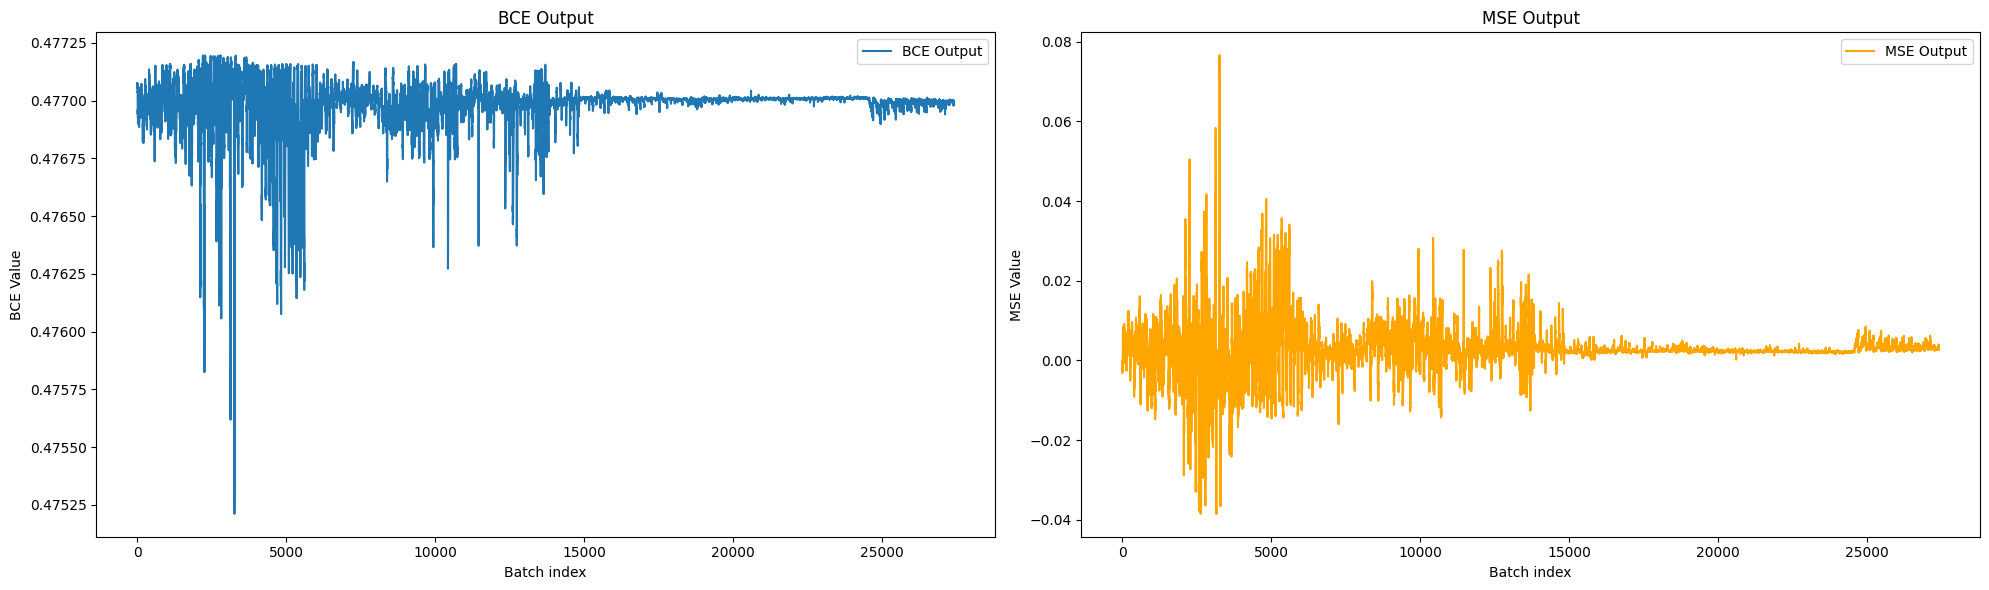

In [70]:





# Create a figure and plot both outputs
plt.figure(figsize=(20, 6))

# Plot BCE outputs
plt.subplot(1, 2, 1)
plt.plot(bce_outputs.cpu().numpy(), label='BCE Output')
plt.title('BCE Output')
plt.xlabel('Batch index')
plt.ylabel('BCE Value')
plt.legend()

# Plot MSE outputs
plt.subplot(1, 2, 2)
plt.plot(mse_outputs.cpu().numpy(), label='MSE Output', color='orange')
plt.title('MSE Output')
plt.xlabel('Batch index')
plt.ylabel('MSE Value')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [71]:
import torch
import numpy as np
from scipy.io.wavfile import write


def tensor_to_wav(tensor, filename, sample_rate=44100,cut_off=-1 ):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()[:cut_off]
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data * 32768)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")

# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(mse_outputs, "test_mult_first_bad.wav",sample_rate)

Saved as test_mult_first_bad.wav


In [72]:
from IPython.display import Audio

# Play the .wav file
Audio("test_mult_first_bad.wav")

In [ ]:
in seq embedding, you need the individual file again.  it needs its own embedding at that layer too!!

In [ ]:
#the forward for eval is not super efficient, we only need to run the seq stuff once.  idk.  not super important right now.  


In [ ]:
time "embedding"  pass the t through a layer before you concatenat? not a bad idea

add depth to the bce and mse stuff. 

add time varying encoder part

train longer.  

the trainer should show like, averages.  lets do that before putting it on scc.  get a better idea of what is happening.



In [ ]:
see what the embedding outputs for the padded bits? is it training on it at all?
